In [1]:
%matplotlib inline

import os 
import time
import librosa
import IPython
import librosa.display
import importlib
import matplotlib
import numpy as np
import string as strp
import pr_util as util
import matplotlib.pyplot as plt

from scipy import signal, ndimage

importlib.reload(util)

<module 'pr_util' from '/Users/felipefelix/USP/tcc/code/pr_util.py'>

In [2]:
#y, sr = librosa.load('Rexp/100041.filtered1.wav')
#y, sr = librosa.load('/Users/felipefelix/USP/tcc/dataset/pr_article/experimentos_100/Synallaxis spixi/song/Synallaxis%20spixii0606-1-16.wav.filtered3.wav')
y1, sr1 = librosa.load('/Users/felipefelix/USP/tcc/dataset/pr_article/experimentos_100/Vanellus chilensis/song/Vanellus%20chilensis-2.wav.filtered2.wav')
y2, sr2 = librosa.load('/Users/felipefelix/USP/tcc/dataset/pr_article/experimentos_100/Trogon surrucura/song/10098-2.wav.filtered1.wav')
y3, sr3 = librosa.load('/Users/felipefelix/USP/tcc/dataset/pr_article/experimentos_100/Vanellus chilensis/song/10047-1.wav.filtered1.wav')

#y, sr = librosa.load('Rexp/100025.mp3')
#y, sr = librosa.load('../dataset/pr_article/S_A_C_Base_Parte-1/Campephilus robustus/song/1000136.mp3.filtered1.wav')


In [3]:
IPython.display.Audio(data = y1, rate = sr1)

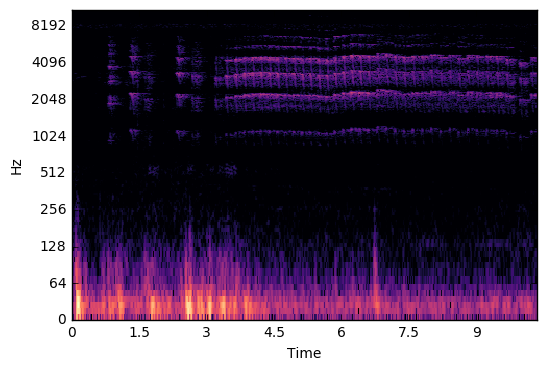

In [4]:
D = librosa.stft(y1, n_fft = 2048)
D = librosa.amplitude_to_db(D, ref=np.max)

librosa.display.specshow(D, y_axis='log', x_axis='time')

In [6]:
IPython.display.Audio(data = y2, rate = sr2)


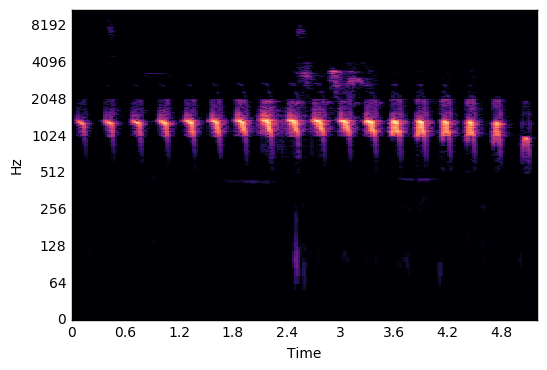

In [7]:
D = librosa.stft(y2, n_fft= 2048)
D = librosa.amplitude_to_db(D, ref=np.max)

librosa.display.specshow(D, y_axis='log', x_axis='time')

In [8]:
IPython.display.Audio(data = y3, rate = sr3)

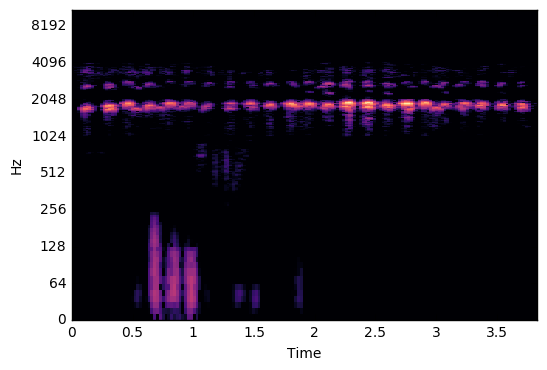

In [9]:
D = librosa.stft(y3, n_fft= 2048)
D = librosa.amplitude_to_db(D, ref=np.max)

librosa.display.specshow(D, y_axis='log', x_axis='time')

In [14]:
y = y2
sr = sr2

Quantidade de samples: 228096
Sample Rate: 22050


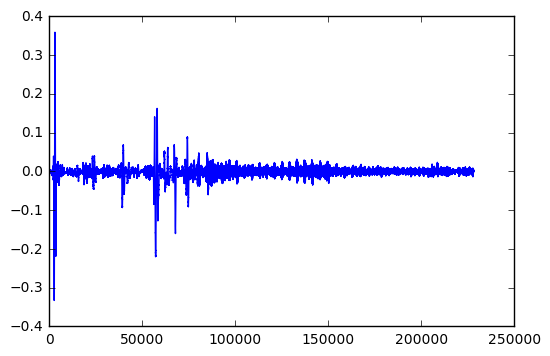

In [6]:
print('Quantidade de samples: {}'.format(len(y)))
print('Sample Rate: {}'.format(sr))
matplotlib.pyplot.plot(y)

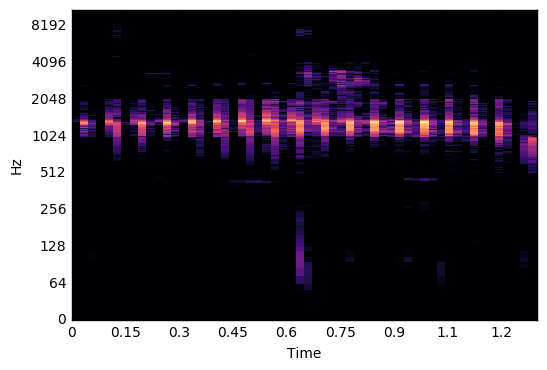

In [14]:
D = librosa.stft(y, n_fft= 2048, hop_length=2048)
D = librosa.amplitude_to_db(D, ref=np.max)

librosa.display.specshow(D, y_axis='log', x_axis='time')

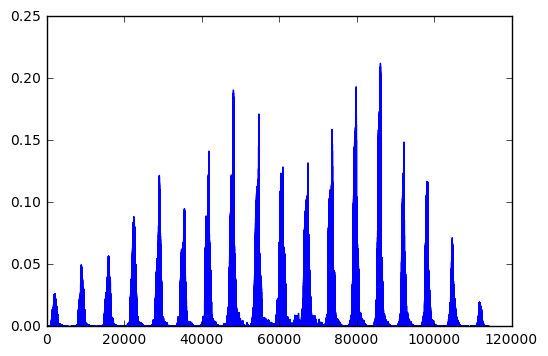

In [15]:
matplotlib.pyplot.plot(np.abs(y))

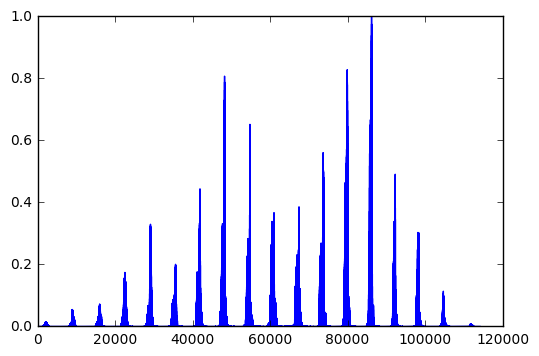

In [16]:
matplotlib.pyplot.plot(np.abs(y/np.max(y))**2)

In [16]:
def CFAR(y, num_cells_guard, num_cells_train, threshold):
    peaks = []
    y_new = np.zeros(len(y))
    
    num_cells_guard_half = round(num_cells_guard/2)
    num_cells_train_half = round(num_cells_train/2)
    num_cells_side = num_cells_guard_half + num_cells_train_half   # num celulas em cada lado da celula teste
    
    for i in range(num_cells_side, y.size - num_cells_side):
        training_cells_1h = y[i-num_cells_train_half-num_cells_guard_half:i-num_cells_guard_half]
        training_cells_2h = y[i+1+num_cells_guard_half:i+1+num_cells_guard_half+num_cells_train_half]
        training_cells = np.concatenate([training_cells_1h, training_cells_2h])
        
        if y[i] > np.mean(training_cells)*threshold:
            y_new[i] = 1
            
    return y_new

def autodetec(y, power, thres, signal_or_change = 'signal'):
    N = len(y)
    y_env = np.abs(y) ** power
    y_new = y.copy()
    print('máximo do envelope {}'.format(np.max(y_env)))
    print('mínimo do envelope {}'.format(np.min(y_env)))
    print('média do envelope {}'.format(np.mean(y_env)))
    thres = np.mean(y_env) * 10
    y2 = np.zeros(N)
    menor = 0
    maior = 0
    
    for y in y_env:
        if y <= thres:
            menor += 1
        else:
            maior += 1
        
    y2[y_env <= thres] = 1
    y2[y_env  > thres] = 2

    print('pct menores: {}'.format(menor/(menor+maior)))
    print('pct maiores: {}'.format(maior/(menor+maior)))

    ## y3: { 2 = silence; 3 = change, 4 = signal}
    
    y3 = (y2[:-1] + y2[1:]).copy()
    
    y3[0] = 3
    y3[-1] = 3
    
    if signal_or_change == 'change':
        y_new[np.where(y3 != 3)[0]] = 0
        y_new[np.where(y3 == 3)[0]] = 1

        #return np.where(y3 == 3)[0]
        return y_new
    elif signal_or_change == 'signal':
        y_new[np.where(y3 != 4)[0]] = 0
        y_new[np.where(y3 == 4)[0]] = 1

        #return np.where(y3 == 4)[0]
        return y_new
    elif signal_or_change == 'both':
        y_new[np.where(y3 != 3)[0]] = 0
        y_new[np.where(y3 != 4)[0]] = 0
        y_new[np.where(y3 == 3)[0]] = 1
        y_new[np.where(y3 == 4)[0]] = 1

        return y_new
    
def estimate_struc_size(y, min_size = 0):
    print("estimate_struc_size")
    non_zeros = np.where(y == 1)[0]
    max_dis = -np.inf
    distances = []
    N = len(non_zeros)
    for i in range(N - 1):
        current_dis = non_zeros[i + 1] - non_zeros[i]
        if current_dis > min_size:
            distances += [current_dis]
    distances = np.array(distances)
    print("distances: {}".format(distances))
    #distances = distances[distances < np.percentile(distances, 99)]
    return int(np.percentile(distances, 99))

def dilate_both_and(y_new):
     #7501*2
    struc_size = estimate_struc_size(y_new)
    print(struc_size)
    struc_size *= 2
    struc_size -= 1
    half_size = int(struc_size/2)
    struc_l = np.array([1] * struc_size)
    struc_l[:half_size] = 0
    struc_r = np.array([1] * struc_size)
    struc_r[half_size:] = 0
    #plt.ylim([-2,2])
    y_filtered_l = ndimage.morphology.binary_dilation(y_new, struc_l, iterations=10)
    #plt.plot(y_filtered_l)
    y_filtered_r = ndimage.morphology.binary_dilation(y_new, struc_r, iterations=10)
    #plt.plot(y_filtered_r)
    y_filtered = np.logical_and(y_filtered_l, y_filtered_r)
    
    
    #plt.plot(y_filtered)
    return y_filtered

def durations_syllable(y):
    durations = []
    N = len(y)
    i = 0
    init = 0
    end = 0
    syllable = y[0] == 1
    
    while (i < N):
        if (y[i] == 1 and not syllable):
            init = i
            syllable = True
        if (y[i] == 0 and syllable):
            end = i - 1
            durations += [end - init]
            syllable = False
        i += 1
    return durations

def filter_durations(durations, dur_min, dur_max):
    return [dur for dur in durations if dur < dur_max and dur > dur_min]

def fix_durations(durations, struc):
    size_struc = len(struc)
    return [dur - (int(size_struc/2) - 1) for dur in durations]

def get_syllable_durations(y, sr, min_dur, max_dur):
    y_new = autodetec(y, 2, 0.2, 'signal')
    y_filtered = dilate_both_and(y_new)
    durations = durations_syllable(y_filtered)
    durations = filter_durations(durations, util.time_to_samples(min_dur, sr), util.time_to_samples(max_dur, sr))
    return durations

# Aqui a função ainda retornava o vetor de distancias
#for min_size in [100, 500, 1000]:
#    print(min_size)
#    dist = estimate_struc_size(y_new, min_size)
#    dist = dist[dist < np.percentile(dist, 99)]
#    print("len: {}".format(len(dist)))
#    print("max: {}".format(np.max(dist)))
#    print("min: {}".format(np.min(dist)))
#    print("mean: {}".format(np.mean(dist)))
#    print("std: {}".format(np.std(dist)))
#    print("median: {}".format(np.median(dist)))
#    print("90% percentile: {}".format(np.percentile(dist, 90)))
#    print("95% percentile: {}".format(np.percentile(dist, 95)))
#    print("99% percentile: {}".format(np.percentile(dist, 99)))

#markers_on = autodetec(y, 2, 0.2)

In [19]:
y_new = autodetec(y, 2, 0.2, 'signal')
y_new_CFAR = CFAR(y, 200, 10000, 100)

máximo do envelope 0.04503249749541283
mínimo do envelope 8.738356670525498e-18
média do envelope 0.0006542822811752558
pct menores: 0.970282721412556
pct maiores: 0.029717278587443947


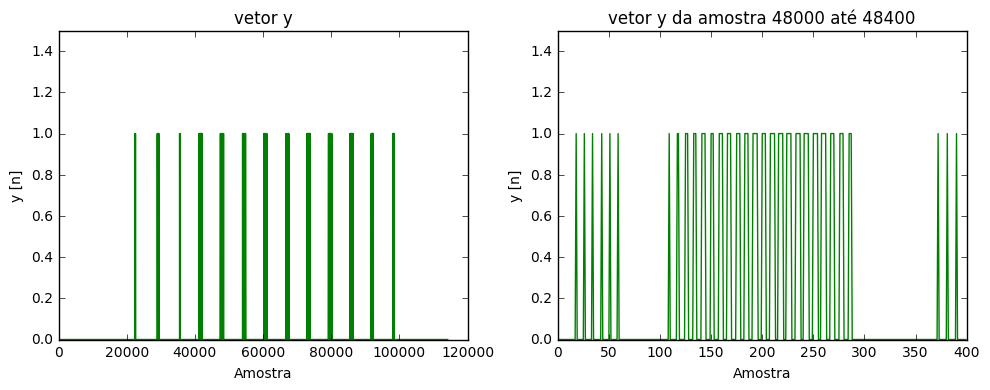

In [46]:

# zoom
# plt.plot(y_new[48000:48400], 'g')
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
plt.ylim([0,1.5])
plt.plot(y_new, 'g')
plt.title('vetor y')
plt.xlabel('Amostra')
plt.ylabel('y [n]')

ax = fig.add_subplot(122)
plt.ylim([0,1.5])
plt.plot(y_new[48000:48400], 'g')
plt.title('vetor y da amostra 48000 até 48400')
plt.xlabel('Amostra')
plt.ylabel('y [n]')

plot = fig.tight_layout()



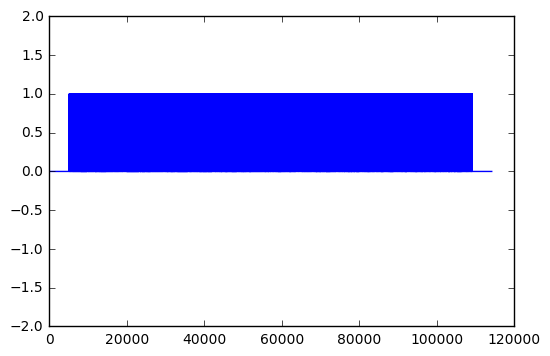

In [39]:
plt.ylim([-2,2])
plt.plot(y_new_CFAR)

In [417]:
#for tam in [0, 1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 1000, 10000]:
#    struc_size = estimate_struc_size(y_new, tam)
#    print("tam_min: {} struc_size: {}".format(tam, struc_size))
struc_size = estimate_struc_size(y_new, 0)
print("tam:{} struc:{} ".format(tam, struc_size))
#struc_size = int(np.median(dist))
#print("median: {}".format(struc_size))

estimate_struc_size
distances: [7990    1   37 ...,    2    1 2429]
tam:10000 struc:59 


In [40]:
y_filtered = dilate_both_and(y_new)

estimate_struc_size
distances: [22338     1     7 ...,     1     1 15801]
7


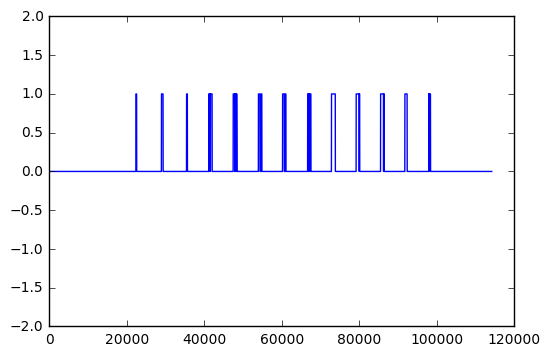

In [41]:
plt.ylim([-2,2])
plt.plot(y_filtered)

In [379]:
y_play = y[y_filtered]
IPython.display.Audio(data = y_play, rate = sr)

In [420]:
durations = durations_syllable(y_filtered)
print('Antes de filtrar: {}'.format(durations))
#durations = fix_durations(durations, struc)
durations = filter_durations(durations, util.time_to_samples(0.02, sr), util.time_to_samples(3, sr))
print(np.percentile(durations, 90))
print(util.samples_to_time(np.percentile(durations, 90), sr))
print('Depois da filtragem e ajuste: {}'.format(durations))
print("tamanho médio das sílabas em samples: {}".format(np.mean(durations)))
print("tamanho médio das sílabas em segundos: {}".format(util.samples_to_time(np.mean(durations), sr)))

#print('Tamanho das sílabas: {}, {}'.format(util.samples_to_time(durations[0], sr), util.samples_to_time(durations[1], sr)))
#print('Tamanho das sílabas ground-truth: 1.648s, 1.264')
#print('Média das sílabas: {}'.format(util.samples_to_time(np.mean(durations), sr)))
#print('Média das sílabas ground-truth: 1.456')

Antes de filtrar: [852, 974, 1071, 1039, 1158, 698, 708, 1121, 827]
1128.4
0.0511746031746
Depois da filtragem e ajuste: [852, 974, 1071, 1039, 1158, 698, 708, 1121, 827]
tamanho médio das sílabas em samples: 938.6666666666666
tamanho médio das sílabas em segundos: 0.04256991685563114


In [357]:
#get_syllable_durations(y, sr, 0.1, 3)

In [358]:
def plot_with_marks(y, y_filtered, n_fft = 2048, save_pic = False):
    markers_on = np.where(y_filtered == True)[0]
    print(markers_on)
    markers_on = markers_on.tolist()
    D = librosa.stft(y, hop_length = n_fft, n_fft = n_fft)
    D = librosa.amplitude_to_db(D, ref=np.max)
    M, N = D.shape

    for i in markers_on:
        D[:int(M/20), int(np.floor(i/n_fft))] = 10
        
    librosa.display.specshow(D, y_axis='log', x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    if (save_pic): plt.savefig("../pics/file.power_{}.thres_{}.nfft_{}.svg".format(power, thres, n_fft))
    #return markers_on


#plot_with_marks(y, 2, 0.2, 2048)

[ 4317  4318  4319 ..., 41148 41149 41150]


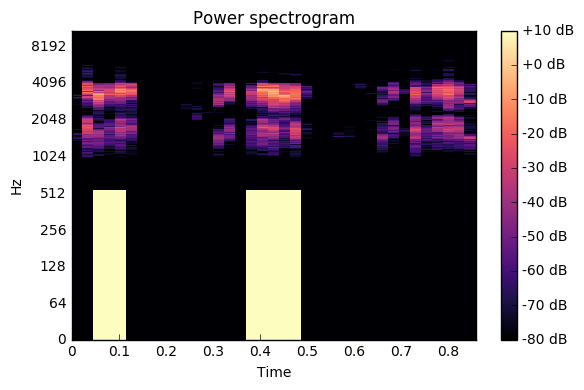

In [359]:
plot_with_marks(y, y_filtered)